# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-25

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg containing spots  
> Output file(s): .csv file containing data on all detected spots  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl, pathlib, math 

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [1]:
# Importing dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import ipympl
from pathlib import Path
import math
import microspot_util as msu
import microspot_util.plots as plots
#%matplotlib widget

## User Input

In [2]:
inputfile=Path(r"test_images\edge_halo.tif")
outputfolder=Path(r"output")

first_spot="A1"
last_spot="P20"

### Extracting Information from User Input

In [3]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

## Loading the Image File

[Text(0.5, 1.0, 'Grayscale Image')]

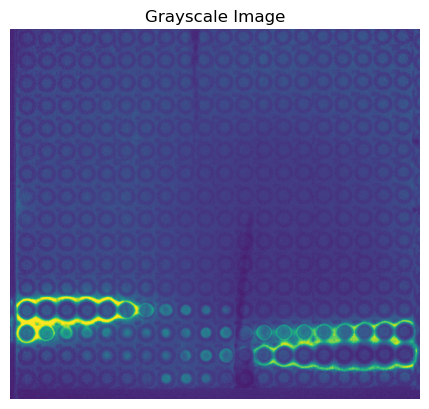

In [4]:
# Load and prepare raw image file.
raw_img=msu.prep_img(inputfile, invert=True)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


## Inital Spot and Grid detection

Spot at Coordinates (1610, 1983) could not be drawn: Out of Bounds.


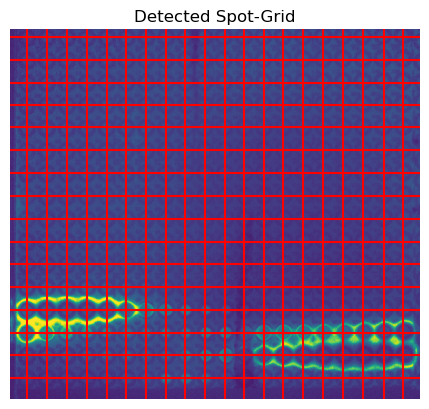

In [5]:
# Inital spot-detection.
init_spots=msu.spot.detect(raw_img,grid_props["spot_nr"])

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for i_spot in init_spots: 
    i_spot.draw_spot(dot_img,255,5)

# Detection of gridlines.
gridlines=msu.gridline.detect(dot_img)
hor_line=[line for line in gridlines if line.alignment=="hor"]
vert_line=[line for line in gridlines if line.alignment=="vert"]

# Calculate the intersections of all horizontal lines with all vertical lines.
grid_points=[]
for h_l in hor_line:
    for v_l in vert_line:
        grid_points.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
plots.plot_grid(fig,ax,raw_img,hor_line+vert_line)

## Spot Correction, Sorting and Intensity Determination

In [6]:
# Initializing corrected spotlist
corr_spots=[]

# Loop over all spots and gridpoints
for s_point in init_spots:
    dist_list=[]
    for g_point in grid_points:

        # Calculate the distance between the points and append it to the running list.
        pointdist=g_point.eval_distance(s_point.x,s_point.y)
        dist_list.append(pointdist)
    
    # If the distance between the current spot and any gridpoint is <= it is accepted as correct.
    if min(dist_list)<=10:
        corr_spots.append(s_point)

# Loop over all gridpoints and backfill the ones that are not associated with a spot.
for g_point in grid_points:
    if g_point.min_dist>10:
        msu.spot.backfill(corr_spots,g_point.x,g_point.y)

sort_spots=msu.spot.sort_grid(corr_spots,
                            row_conv=row_conv_inv,
                            row_start=grid_props["rows"]["bounds"][0],
                            col_start=grid_props["columns"]["bounds"][0])

for s in sort_spots:
    s.get_intensity(raw_img)

## Halo Detection

In [7]:
# Detect Halos using the halo.detect method.
halos=msu.halo.detect(raw_img)
halo_df=msu.halo.create_df(halos)

# Assign halos to their spot.
for s in sort_spots:
    s.assign_halo(halos)


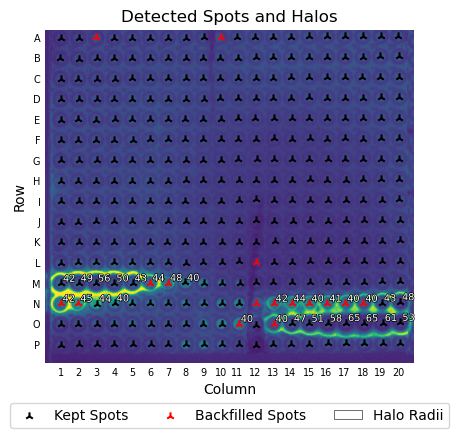

In [8]:
# Display the corrected and sorted spotlist.
sort_spot=msu.spot.create_df(sort_spots)

fig,ax=plt.subplots()
plots.plot_result(fig,ax,raw_img,sort_spot,grid_props)


## Heatmap

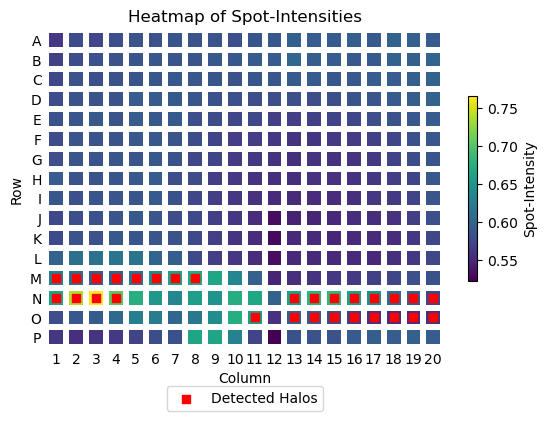

In [9]:
fig,ax=plt.subplots()
plots.plot_heatmap(fig,ax,sort_spot,grid_props)

## Save Results

In [10]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_spots.to_csv(outputfile)

AttributeError: 'list' object has no attribute 'to_csv'